# Dependencies

In [2]:
!pip install camb
!pip install cosmopower;
!git clone https://github.com/cosmopower-organization/lcdm.git;
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for camb: filename=camb-1.4.0-py3-none-any.whl size=1064543 sha256=d3a5242c2647bb7704d00c9a59c41c38e32eac626c2a670d3a2f9cfdbed86335
  Stored in directory: /root/.cache/pip/wheels/dc/70/4d/f35f1f33a03e0a3de319e24a30910aa3fe8a9f1f5386636859
Successfully built camb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'lcdm'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 34
Unpacking objects: 100% (39/39), 119.37 MiB | 10.46 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 91.8 kB 1.8 MB/s

# Imports

In [3]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import os
from IPython.display import clear_output

import cosmopower
import camb

import uncertainties as uc
import uncertainties.umath as um

from tqdm import tqdm_notebook as tqdm

#Reading data

<ipython-input-4-0bd1b30daf91>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = pd.Series(df.columns.str.replace("<>\s", ""))


       \ell,        cls,  \sigma_\ell
0        0.0    0.000000     0.000000
1        0.0    0.000000     0.000000
2        2.0  150.244398    19.528160
3        3.0  502.091022    11.415822
4        4.0  111.792554     7.614465
...      ...         ...          ...
1496  1496.0    0.002186     0.001222
1497  1497.0    0.002168     0.001219
1498  1498.0    0.002219     0.001216
1499  1499.0    0.002182     0.001213
1500  1500.0    0.002274     0.001210

[1501 rows x 3 columns]


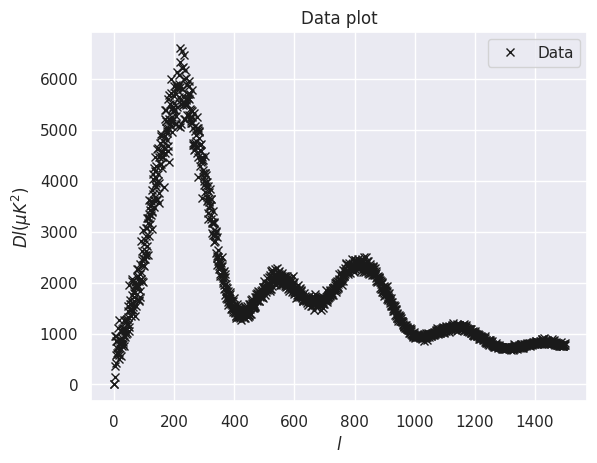

In [4]:
data_path = "data_ombh2_omch2_60muK.dat"
df = pd.read_csv(data_path, delimiter = " ")
df.columns = pd.Series(df.columns.str.replace("<>\s", ""))

ell = df[df.columns[0]]

cls = df[df.columns[1]]
dls = cls *  ell * (ell + 1) / (2 * np.pi)

sigma_ell = df[df.columns[2]] *  ell * (ell + 1) / (2 * np.pi)

plt.plot(ell, dls, "kx", label = "Data")
plt.xlabel("$l$")
plt.ylabel("$Dl(\mu K^2)$")
plt.title(f"Data plot")
plt.legend(loc = "best")

print(df)

#Loading the emulator

In [5]:
#finding the path towards the emulator
root_path = os.path.abspath("")
#path_to_cosmopower_organization = root_path + '/cosmopower-organization/'
path_to_emulators = root_path + '/lcdm/'

In [6]:
#dictionary for all possible models names -> possible future expansions
emulator_dict = {}

emulator_dict['lcdm'] = {} #we are only interested in lcdm for now

#setting up the names of the required files for lcdm
emulator_dict['lcdm']['TT'] = 'TT_v1'
emulator_dict['lcdm']['TE'] = 'TE_v1'
emulator_dict['lcdm']['EE'] = 'EE_v1'
emulator_dict['lcdm']['PP'] = 'PP_v1'
emulator_dict['lcdm']['PKNL'] = 'PKNL_v1'
emulator_dict['lcdm']['PKL'] = 'PKL_v1'
emulator_dict['lcdm']['DER'] = 'DER_v1'
emulator_dict['lcdm']['DAZ'] = 'DAZ_v1'
emulator_dict['lcdm']['HZ'] = 'HZ_v1'
emulator_dict['lcdm']['S8Z'] = 'S8Z_v1'

cp_tt_nn = {}
cp_te_nn = {}
cp_ee_nn = {}
cp_pp_nn = {}
cp_pknl_nn = {}
cp_pkl_nn = {}
cp_der_nn = {}
cp_da_nn = {}
cp_h_nn = {}
cp_s8_nn = {}

In [7]:
#putting paths towards the emulators inside the dictionary, we are only
#interested in the tt one here
#path_to_emulators = root_path + mp +'/'

mp = "lcdm"
cp_tt_nn[mp] = cosmopower.cosmopower_NN(restore = True,
                          restore_filename = path_to_emulators + 'TTTEEE/' + emulator_dict[mp]['TT'])

#Parameters object

In [8]:
class Parameters():
    def __init__(self, H0, ombh2, omch2, As, ns, tau, lmax):
        self.H0 = H0
        self.ombh2 = ombh2
        self.omch2 = omch2
        self.As = As
        self.ns = ns
        self.tau = tau
        self.lmax = lmax

    def __str__(self):
        return f"H0 = {self.H0:.3f}, ombh2 = {self.ombh2:.3f}, omch2 = {self.omch2:.3f}, As = {self.As:.3e}, ns = {self.ns:.3f}, tau = {self.tau:.3f}"

    def CAMB_lcdm(self):
        pars = camb.CAMBparams()

        pars.set_cosmology(H0 = self.H0, ombh2 = self.ombh2, 
                          omch2 = self.omch2, mnu = 0.06, tau = self.tau,
                          omk = 0);

        pars.InitPower.set_params(As = 2e-9, ns = self.ns, r = 0);
        pars.set_for_lmax(lmax = self.lmax, lens_potential_accuracy = 0);

        results = camb.get_results(pars)

        power = results.get_cmb_power_spectra(pars, CMB_unit = "muK")

        totCL = power["total"]
        ls = np.arange(totCL.shape[0])

        return totCL[:, 0]

    def CP_lcdm(self):
        params_settings = {
                   'H0': self.H0,
                   'omega_b': self.ombh2,
                   'omega_cdm': self.omch2,
                   'ln10^{10}A_s': np.log(self.As * 1e10),
                   'tau_reio': self.tau,
                   'n_s': self.ns,
                   }  

        mp = 'lcdm'

        params_cp = {}
        for key, value in params_settings.items():
            params_cp[key] = [value]

        predicted_tt_spectrum = cp_tt_nn[mp].ten_to_predictions_np(params_cp)

        #dimensionless to muK^2
        return predicted_tt_spectrum[0][:self.lmax + 1] * 1e12 * 2.72548**2

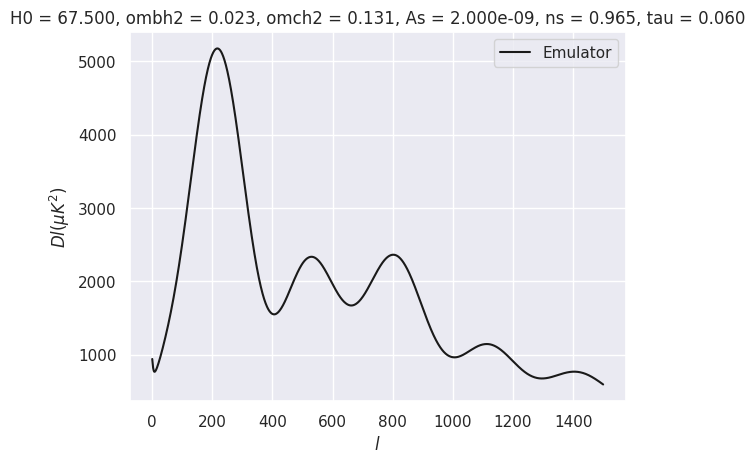

In [9]:
p = Parameters(H0 = 67.500, ombh2 = 0.0226, omch2 = 0.131, As = 2.000e-09, ns = 0.965, tau = 0.060, lmax = 1500)

plt.plot(p.CP_lcdm(), "k-", label = "Emulator")
plt.xlabel("$l$")
plt.ylabel("$Dl(\mu K^2)$")
plt.title(f"H0 = 67.500, ombh2 = {p.ombh2:.3f}, omch2 = {p.omch2:.3f}, As = 2.000e-09, ns = 0.965, tau = 0.060")
plt.legend(loc = "best")


#Likelihood

In [10]:
def check_range(p):
    if p.ombh2 < 0.01933:
        return False

    if p.ombh2 > 0.02533:
        return False

    if p.omch2 < 0.08:
        return False

    if p.omch2 > 0.2:
        return False

    return True

In [11]:
def chi_sq(p):
    #return np.sum((dls[2:] - p.CP_lcdm()[2 : len(dls)])**2 / sigma_ell[2:])
    obs = dls[2:]
    exp = p.CP_lcdm()[2:len(dls)]
    '''
    if check_range(p):
        exp = p.CP_lcdm()[2:len(dls)]
    else:
        exp = p.CAMB_lcdm()[2:len(dls)]
    '''

    return np.sum((obs - exp)**2 / exp)

In [12]:
def likelihood(p):
    return np.exp(-chi_sq(p)**2 / 2)

In [13]:
def likelihood_log(p):
    return -chi_sq(p)**2 / 2

# Prior

Text(0, 0.5, 'ombh2 prior')

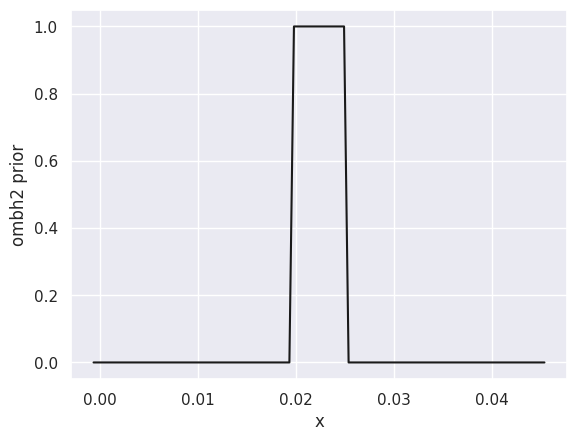

In [14]:
ombh2_low = 0.01933
ombh2_high = 0.02533

ombh2_scale = ombh2_high - ombh2_low

ombh2_pr = scipy.stats.uniform(loc = ombh2_low, scale = ombh2_scale)

x = np.linspace(ombh2_low - 0.02, ombh2_high + 0.02, 100)

pdf = ombh2_pr.pdf(x)
pdf_norm = pdf / np.max(pdf)

plt.plot(x, pdf_norm, 'k-')
plt.xlabel("x")
plt.ylabel("ombh2 prior")

Text(0, 0.5, 'omch2 prior')

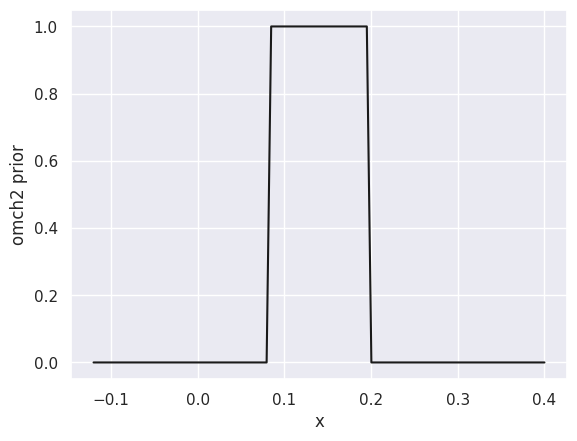

In [15]:
omch2_low = 0.08
omch2_high = 0.20
omch2_scale = omch2_high - omch2_low

omch2_pr = scipy.stats.uniform(loc = omch2_low, scale = omch2_scale)

x = np.linspace(omch2_low - 0.2, omch2_high + 0.2, 100)

pdf = omch2_pr.pdf(x)
pdf_norm = pdf / np.max(pdf)

plt.plot(x, pdf_norm, 'k-')

plt.xlabel("x")
plt.ylabel("omch2 prior")

In [16]:
def prior(p):
    b = ombh2_pr.pdf(p.ombh2)
    c = omch2_pr.pdf(p.omch2)

    if b * c == 0:
        return 0

    return 1

#Posterior

In [17]:
def posterior(p):
    return likelihood(p) * prior(p)

In [18]:
def posterior_log(p):
    ombh2_post = ombh2_pr.pdf(p.ombh2)
    omch2_post = omch2_pr.pdf(p.omch2)

    return likelihood_log(p) + np.log(ombh2_post * omch2_post)

#MCMC

## Initial variables

In [61]:
n_steps = 1500

cov = np.array([[0.1 * 0.029 , 0],
                [0, 0.1 * 0.121]])

print(cov)

[[0.0029 0.    ]
 [0.     0.0121]]


## Utils

In [20]:
def get_parameters_object(ombh2_new, omch2_new):
    return Parameters(H0 = 67.5, ombh2 = ombh2_new, omch2 = omch2_new, 
                      As = 2e-9, ns = 0.965, tau = 0.06, lmax = len(dls))

In [21]:
def get_normal_distribution(p):
    means = [p.ombh2, p.omch2]

    return scipy.stats.multivariate_normal(means, cov)

In [22]:
get_normal_distribution(get_parameters_object(1, 2)).rvs()

array([1.0894115 , 1.81960766])

## Runtime

Debugger - will be deleted later

In [23]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00


In [24]:
%pdb on

Automatic pdb calling has been turned ON


This version of the code forces the new parameter proposition to be inside the emulator's ranges with a `while()` loop in order to avoid using camb.

In [62]:
ombh2_s = []
omch2_s = []

n_jumps = 0
for n in tqdm(range(n_steps), desc = "Progress"):
    #first step guessing
    if n == 0:
        #pick random number from the prior distribution
        ombh2_first_guess = ombh2_pr.rvs(1)[0]
        omch2_first_guess = omch2_pr.rvs(1)[0]

        #set the current param object as the guess
        p_curr = get_parameters_object(ombh2_first_guess, omch2_first_guess)
        #p_curr = get_parameters_object(0.022, 0.122)

    ombh2_s.append(p_curr.ombh2)
    omch2_s.append(p_curr.omch2)

    #pick next guess
    #forcing step proposition to be inside the emulator's range
    while True:
        values_next = get_normal_distribution(p_curr).rvs()
        p_next = get_parameters_object(values_next[0], values_next[1])

        if check_range(p_next):
            break

    #compute posteriors
    post_curr = posterior_log(p_curr)
    post_next = posterior_log(p_next)


    #jump if the next step is closer to the real dist
    if post_curr > post_next:
        p_curr = p_next
        n_jumps += 1
        continue

    #if not, we check if it would be an exploring step
    alpha = post_curr / post_next
    
    u = scipy.stats.uniform.rvs()

    #if so, we explore
    if u < alpha:
        p_curr = p_next
        n_jumps += 1
        continue

    #if everything fails, we discard the step
    n -= 1

In [63]:
n_jumps / n_steps

1.0

ombh2 = 0.0222+/-0.0017
ombh2 = 0.139+/-0.034


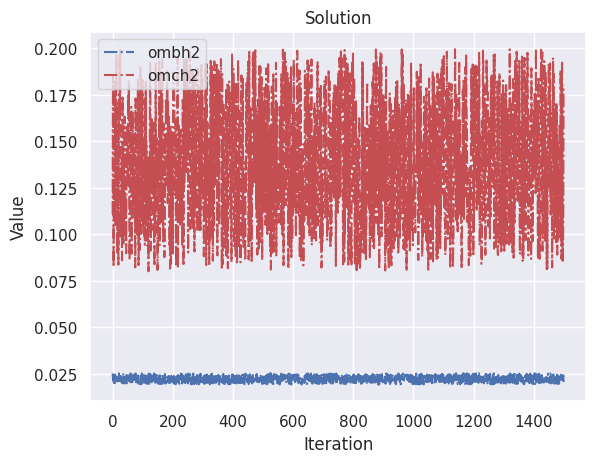

In [64]:
ombh2_fit = uc.ufloat(np.mean(ombh2_s), np.std(ombh2_s))
omch2_fit = uc.ufloat(np.mean(omch2_s), np.std(omch2_s))

print(f"ombh2 = {ombh2_fit}")
print(f"ombh2 = {omch2_fit}")

plt.plot(ombh2_s, "b-.", label = "ombh2")
plt.plot(omch2_s, "r-.", label = "omch2")

plt.title("Solution")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend(loc = "best")

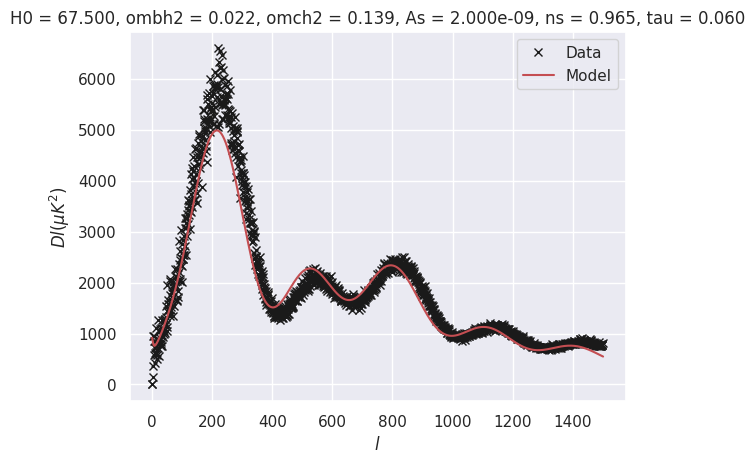

In [65]:
fit = get_parameters_object(ombh2_fit.nominal_value, omch2_fit.nominal_value)

plt.plot(ell, dls, "kx", label = "Data")
plt.plot(fit.CP_lcdm(), "r-", label = "Model")
plt.xlabel("$l$")
plt.ylabel("$Dl(\mu K^2)$")
plt.title(f"H0 = 67.500, ombh2 = {fit.ombh2:.3f}, omch2 = {fit.omch2:.3f}, As = 2.000e-09, ns = 0.965, tau = 0.060")
plt.legend(loc = "best")
